In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from deltalake import DeltaTable

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Decoder
        outputs, _ = self.decoder(hidden)
        outputs = self.fc(outputs[:, -1, :])
        return outputs

class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        sequence = self.data[idx:idx+self.seq_length]
        target = self.data[idx+self.seq_length]
        return sequence, target

def prepare_data(df, window_size):
    # Ensure 'ds' is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Sort by datetime
    df = df.sort_values('ds')
    
    # Prepare sequences
    sequences = []
    targets = []
    for i in range(len(df) - window_size):
        sequence = df.iloc[i:i+window_size]['y'].values
        target = df.iloc[i+window_size]['y']
        sequences.append(sequence)
        targets.append(target)
    
    return sequences, targets

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to("cuda"), batch_targets.to("cuda").unsqueeze(-1)
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

if __name__ == '__main__':

    df = DeltaTable("../deltalake").to_pandas()  # Replace "your_table_name" with actual table name
        
    # Prepare data
    window_size = 77  # As per best_config
    sequences, targets = prepare_data(df, window_size)

    # Normalize data
    scaler = MinMaxScaler()
    scaled_sequences = scaler.fit_transform(sequences)
    scaled_targets = scaler.fit_transform([[target] for target in targets])

    # Create dataset and dataloader
    dataset = StockDataset(scaled_sequences, window_size)
    train_size = int(0.8 * len(dataset))
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_size = 77  # As per best_config
    hidden_size = 300  # As per best_config
    num_layers = 1   # As per best_config
    output_size = 1  # For predicting single value

    model = StockLSTM(input_size, hidden_size, num_layers, output_size).to("cuda")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.008279309926218455)  # As per best_config

    # Train model
    num_epochs = 10000  # As per best_config

    train_model(model, train_loader, criterion, optimizer, num_epochs)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_sequences, batch_targets in val_loader:
            batch_sequences, batch_targets = batch_sequences.to("cuda"), batch_targets.to("cuda").unsqueeze(-1)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

In [2]:
import os
import sys

# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
# sys.path.insert(0, project_root)

if os.path.basename(os.getcwd()) == "notebooks":  
    os.chdir("..")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from deltalake import DeltaTable
from src.utils import WMAPE
import mlflow
import mlflow.pytorch
import psutil
import platform
import socket
import matplotlib.pyplot as plt
import datetime

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Decoder
        outputs, _ = self.decoder(hidden)
        outputs = self.fc(outputs[:, -1, :])
        return outputs

class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        sequence = self.data[idx:idx+self.seq_length]
        target = self.data[idx+self.seq_length]
        return sequence, target

def prepare_data(df, window_size):
    # Ensure 'ds' is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Sort by datetime
    df = df.sort_values('ds')
    
    # Prepare sequences
    sequences = []
    targets = []
    for i in range(len(df) - window_size):
        sequence = df.iloc[i:i+window_size]['y'].values
        target = df.iloc[i+window_size]['y']
        sequences.append(sequence)
        targets.append(target)
    
    return sequences, targets

def log_system_info():
    mlflow.log_param("system", platform.system())
    mlflow.log_param("release", platform.release())
    mlflow.log_param("version", platform.version())
    mlflow.log_param("processor", platform.processor())
    mlflow.log_param("cpu_count", psutil.cpu_count())
    mlflow.log_param("memory_gb", psutil.virtual_memory().total / (1024 ** 3))

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to("cuda"), batch_targets.to("cuda").unsqueeze(-1)
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        mlflow.log_metric("train_loss", avg_loss, step=epoch)

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.enable_system_metrics_logging()
mlflow.set_experiment("stock_lstm_experiment")

df = DeltaTable("deltalake").to_pandas() 
    

window_size = 77  # trocar pra ler o best_config
sequences, targets = prepare_data(df, window_size)

# Normalize data
scaler = MinMaxScaler()
scaled_sequences = scaler.fit_transform(sequences)
scaled_targets = scaler.fit_transform([[target] for target in targets])

# Create dataset and dataloader
dataset = StockDataset(scaled_sequences, window_size)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = 77  # trocar pra ler o best_config
hidden_size = 300  # trocar pra ler o best_config
num_layers = 1   # trocar pra ler o best_config
learning_rate = 0.008279309926218455  # trocar pra ler o best_config
batch_size = 32  # trocar pra ler o best_config
output_size = 1  # For predicting single value


model = StockLSTM(input_size, hidden_size, num_layers, output_size).to("cuda")
criterion = WMAPE() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # trocar pra ler o best_config

# Train model
num_epochs = 15 #10000  # trocar pra ler o best_config

In [4]:
num_epochs = 5

In [5]:
with mlflow.start_run():
    log_system_info()
    
    # Log model parameters
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("output_size", output_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", learning_rate)

    train_model(model, train_loader, criterion, optimizer, num_epochs)

2024/12/31 18:45:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/5], Loss: 1.0053
Epoch [2/5], Loss: 1.0021
Epoch [3/5], Loss: 1.0014
Epoch [4/5], Loss: 1.0009


2024/12/31 18:47:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/31 18:47:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Epoch [5/5], Loss: 1.0006
🏃 View run gaudy-jay-324 at: http://127.0.0.1:5000/#/experiments/2/runs/71fa8e68a47945f1b3a4f7957dc98fc6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [6]:
# Save the model
mlflow.pytorch.log_model(model, "stock_lstm_model")

# Evaluate on validation set
model.eval()
val_loss = 0
predictions = []
actuals = []
with torch.no_grad():
    for batch_sequences, batch_targets in val_loader:
        batch_sequences, batch_targets = batch_sequences.to("cuda"), batch_targets.to("cuda").unsqueeze(-1)
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets)
        val_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_targets.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")
mlflow.log_metric("val_loss", avg_val_loss)

2024/12/31 18:47:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/12/31 18:48:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/12/31 18:48:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Loss: 1.0005


In [10]:
len(actuals)

17793

In [12]:
len(predictions)

557

In [ ]:
import numpy as np
predictions = np.stack(predictions)
actuals = np.stack(actuals)

In [26]:
actuals.shape[0]

17793

In [23]:


predictions_df = pd.DataFrame({
    "ds": df["ds"].iloc[-len(predictions):],
    "Predicted": predictions
})

actuals_df = pd.DataFrame({
    "ds": df["ds"].iloc[-len(actuals):],
    "Actual": actuals
})

ValueError: Per-column arrays must each be 1-dimensional

TypeError: no numeric data to plot

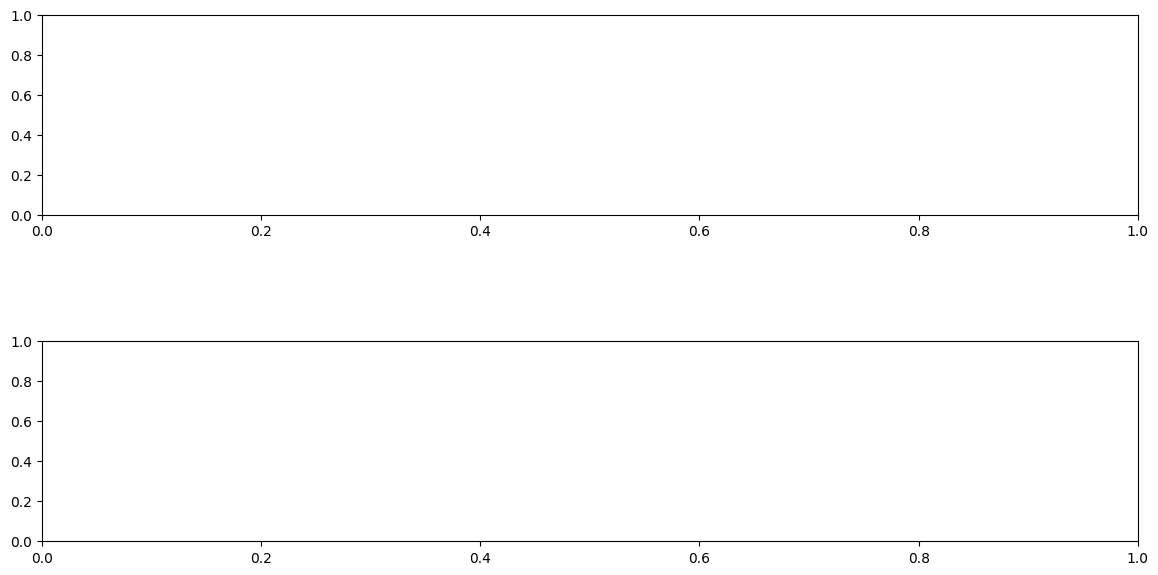

In [15]:
# Plot and save the figure
fig, ax = plt.subplots(2, 1, figsize=(1280 / 96, 720 / 96))
fig.tight_layout(pad=7.0)
for ax_i, unique_id in enumerate(["ABEV3", "BBAS3"]):
    plot_df = pd.concat(
        [
            actuals_df.loc[df["unique_id"] == unique_id].tail(30),
            predictions_df.loc[df["unique_id"] == unique_id],
        ]
    ).set_index("ds")
    plot_df[["Actual", "Predicted"]].plot(ax=ax[ax_i], linewidth=2, title=unique_id)

plot_path = f"reports/forecast_plot_{datetime.datetime.now().date()}.png"
plt.savefig(plot_path)
mlflow.log_artifact(plot_path)